# Generating Rest Frame SEDs from a Parametric Galaxy
<br>
Example for generating the rest-frame spectrum for a parametric galaxy including<br>
photometry. This example will:<br>
- build a parametric galaxy (see make_sfzh)<br>
- calculate spectral luminosity density<br>


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from synthesizer.filters import FilterCollection
from synthesizer.grid import Grid
from synthesizer.parametric.sfzh import SFH, ZH, generate_sfzh
from synthesizer.parametric.galaxy import Galaxy
from synthesizer.plt import single, single_histxy, mlabel
from unyt import yr, Myr
from astropy.cosmology import Planck18 as cosmo

In [3]:
# Define the grid
grid_name = "test_grid"
grid_dir = "../../../tests/test_grid/"
grid = Grid(grid_name, grid_dir=grid_dir)

In [4]:
# --- define the parameters of the star formation and metal enrichment histories
sfh_p = {'duration': 10 * Myr}
Z_p = {'log10Z': -2.0}  # can also use linear metallicity e.g. {'Z': 0.01}
stellar_mass = 1E8

# --- define the functional form of the star formation and metal enrichment histories
sfh = SFH.Constant(sfh_p)  # constant star formation
print(sfh)  # print sfh summary
Zh = ZH.deltaConstant(Z_p)  # constant metallicity

# --- get the 2D star formation and metal enrichment history for the given SPS grid. This is (age, Z).
sfzh = generate_sfzh(grid.log10ages, grid.metallicities, sfh, Zh, stellar_mass=stellar_mass)

# --- create a galaxy object
galaxy = Galaxy(sfzh)

----------
SUMMARY OF PARAMETERISED STAR FORMATION HISTORY
<class 'synthesizer.parametric.sfzh.SFH.Constant'>
duration: 10 Myr
median age: 5.00 Myr
mean age: 5.00 Myr
----------



Pure stellar spectra
Intrinsic spectra
Simple dust and gas screen
CF00 model
Pacman model
Pacman model (no Ly-alpha escape, and no dust)
Pacman model (complex)
CF00 implemented within the Pacman model


/Users/sw376/Dropbox/Research/projects/synthesizer/venv/lib/python3.10/site-packages/unyt/array.py:1802: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


(<Figure size 350x500 with 1 Axes>,
 <Axes: xlabel='$\\rm log_{10}(\\lambda/\\AA)$', ylabel='$\\rm log_{10}(L_{\\nu}/erg\\ s^{-1}\\ Hz^{-1} M_{\\odot}^{-1})$'>)

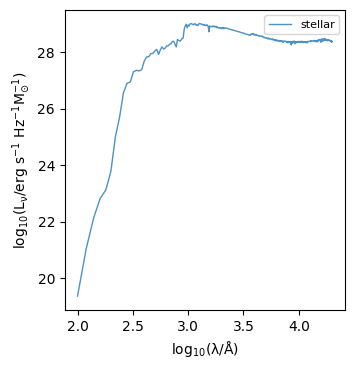

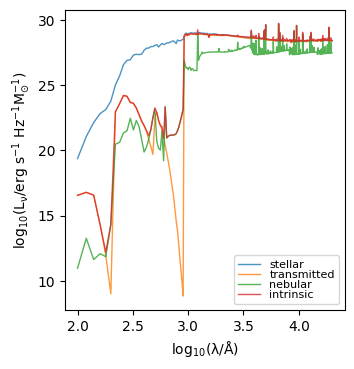

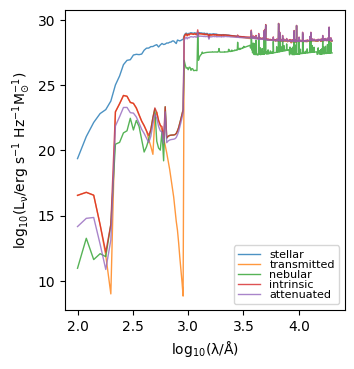

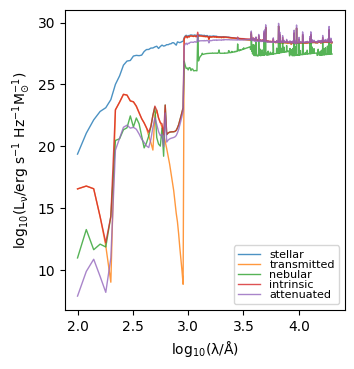

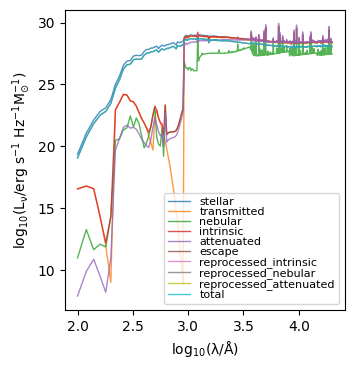

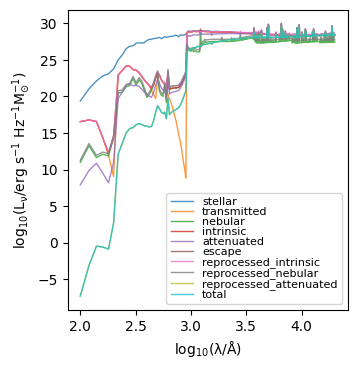

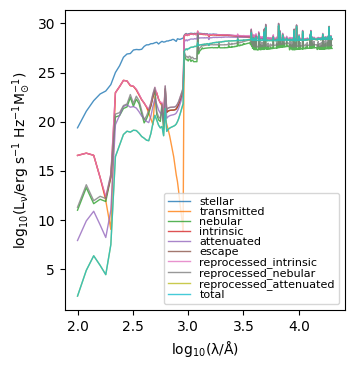

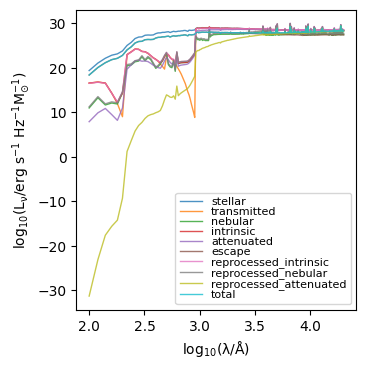

In [5]:
# # --- generate pure stellar spectra alone
galaxy.get_spectra_stellar(grid)
print("Pure stellar spectra")
galaxy.plot_spectra()

# # --- generate intrinsic spectra (which includes reprocessing by gas)
galaxy.get_spectra_intrinsic(grid, fesc = 0.5)
print("Intrinsic spectra")
galaxy.plot_spectra()

# # --- simple dust and gas screen
galaxy.get_spectra_screen(grid, tauV = 0.1, fesc = 0.5)
print("Simple dust and gas screen")
galaxy.plot_spectra()

# --- CF00 model
galaxy.get_spectra_CharlotFall(grid, tauV_ISM=0.1, tauV_BC=0.1, alpha_ISM=-0.7, alpha_BC=-1.3)
print("CF00 model")
galaxy.plot_spectra()

# # --- pacman model
galaxy.get_spectra_pacman(grid, tauV = 0.1, fesc = 0.5)
print("Pacman model")
galaxy.plot_spectra()

# # --- pacman model (no Lyman-alpha escape and no dust)
galaxy.get_spectra_pacman(grid, fesc = 0.0, fesc_LyA = 0.0)
print("Pacman model (no Ly-alpha escape, and no dust)")
galaxy.plot_spectra()

# # --- pacman model (complex)
galaxy.get_spectra_pacman(grid, fesc=0.0, fesc_LyA=0.5, tauV=0.6)
print("Pacman model (complex)")
galaxy.plot_spectra()

# --- CF00 model implemented within pacman model
galaxy.get_spectra_pacman(grid, fesc = 0.1, fesc_LyA = 0.1, tauV=[1.,1.], alpha = [-1,-1], CF00=True)
print("CF00 implemented within the Pacman model")
galaxy.plot_spectra()

In [6]:
# print galaxy summary
print(galaxy)
sed = galaxy.spectra['total']
print(sed)

----------
SUMMARY OF PARAMETRIC GALAXY
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣀⣀⡀⠒⠒⠦⣄⡀⠀⠀⠀⠀⠀⠀⠀
        ⠀⠀⠀⠀⠀⢀⣤⣶⡾⠿⠿⠿⠿⣿⣿⣶⣦⣄⠙⠷⣤⡀⠀⠀⠀⠀
        ⠀⠀⠀⣠⡾⠛⠉⠀⠀⠀⠀⠀⠀⠀⠈⠙⠻⣿⣷⣄⠘⢿⡄⠀⠀⠀
        ⠀⢀⡾⠋⠀⠀⠀⠀⠀⠀⠀⠀⠐⠂⠠⢄⡀⠈⢿⣿⣧⠈⢿⡄⠀⠀
        ⢀⠏⠀⠀⠀⢀⠄⣀⣴⣾⠿⠛⠛⠛⠷⣦⡙⢦⠀⢻⣿⡆⠘⡇⠀⠀
        ---+-+-+-+-+-+-+-+-+-+-+-+---
           |S|Y|N|T|H|E|S|I|Z|E|R|
        ---+-+-+-+-+-+-+-+-+-+-+-+---
        ⠀⠀⢸⡇⠸⣿⣷⠀⢳⡈⢿⣦⣀⣀⣀⣠⣴⣾⠟⠁⠀⠀⠀⠀⢀⡎
        ⠀⠀⠘⣷⠀⢻⣿⣧⠀⠙⠢⠌⢉⣛⠛⠋⠉⠀⠀⠀⠀⠀⠀⣠⠎⠀
        ⠀⠀⠀⠹⣧⡀⠻⣿⣷⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣠⡾⠃⠀⠀
        ⠀⠀⠀⠀⠈⠻⣤⡈⠻⢿⣿⣷⣦⣤⣤⣤⣤⣤⣴⡾⠛⠉⠀⠀⠀⠀
        ⠀⠀⠀⠀⠀⠀⠈⠙⠶⢤⣈⣉⠛⠛⠛⠛⠋⠉⠀⠀⠀⠀⠀⠀⠀⠀
        ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠉⠉⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
<class 'synthesizer.parametric.galaxy.Galaxy'>
log10(stellar mass formed/Msol): 8.0
available SEDs: ['stellar', 'transmitted', 'nebular', 'intrinsic', 'attenuated', 'escape', 'reprocessed_intrinsic', 'reprocessed_nebular', 'reprocessed_attenuated', 'total']
available lines: []
available images: []
----------

----------
SUMMARY OF SED 
Number of wavelength points: 995 
----------


In [7]:
# generate broadband photometry
tophats = {'U': {'lam_eff': 3650, 'lam_fwhm': 660},
           'V': {'lam_eff': 5510, 'lam_fwhm': 880},
           'J': {'lam_eff': 12200, 'lam_fwhm': 2130}}
fc = FilterCollection(tophat_dict=tophats, new_lam=grid.lam)
bb_lnu = sed.get_broadband_luminosities(fc)
print(bb_lnu)

{'U': unyt_quantity(7.12341922e+27, 'erg/(Hz*s)'), 'V': unyt_quantity(7.11250258e+27, 'erg/(Hz*s)'), 'J': unyt_quantity(1.47626e+28, 'erg/(Hz*s)')}
